In [87]:
import sys 
import numpy as np # linear algebra
from scipy.stats import randint
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv), data manipulation as in SQL
import matplotlib.pyplot as plt # this is used for the plot the graph 
import matplotlib.dates as mdates
import seaborn as sns # used for plot interactive graph. 
from sklearn.model_selection import train_test_split # to split the data into two parts
#from sklearn.cross_validation import KFold # use for cross validation
from sklearn.preprocessing import StandardScaler # for normalization
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline # pipeline making
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import SelectFromModel
from sklearn import metrics # for the check the error and accuracy of the model
from sklearn.metrics import mean_squared_error,r2_score

## for Deep-learing:
import keras
from keras.layers import Dense
from keras.models import Sequential
from keras.utils import to_categorical
from keras.optimizers import SGD 
from keras.callbacks import EarlyStopping
#from keras.utils import np_utils
import itertools
from keras.layers import LSTM
from keras.layers import Conv1D
from keras.layers import MaxPooling1D
from keras.layers import Dropout

In [88]:
df = pd.read_csv('../input/teresopolis-2016-2023-precos-medios.csv', sep=',', 
                 parse_dates={'dt' : ['Ano', 'Mês', 'Dia']},
                 low_memory=False, na_values=['nan','?'], index_col='dt')

In [89]:
#filtra produto 'Alface Crespa - Roça', mantendo a coluna Preco_unitario
filtered_alface_crespa_roca = df[df['Produto'] == 'Alface Crespa - Roça'][['Preco_unitario']]

#agrupa por semana
filtered_alface_crespa_roca = filtered_alface_crespa_roca.resample('W').mean()

#preenche valores faltantes usando interpolação linear
filtered_alface_crespa_roca = filtered_alface_crespa_roca.interpolate(method='linear')

filtered_alface_crespa_roca.index.tz_localize("UTC").tz_convert("America/Sao_Paulo")

#identifica cada semana
filtered_alface_crespa_roca['week'] = filtered_alface_crespa_roca.index.strftime('%Y-w%V')

#ordena por data
filtered_alface_crespa_roca.sort_values(by=['dt'], inplace=True)
filtered_alface_crespa_roca

,Preco_unitario,week
dt,,
2016-04-24,0.61650,2016-w16
2016-05-01,0.42611,2016-w17
2016-05-08,0.43778,2016-w18
2016-05-15,0.43056,2016-w19
2016-05-22,0.44444,2016-w20
...,...,...
2023-08-27,0.40833,2023-w34
2023-09-03,0.37500,2023-w35
2023-09-10,0.35417,2023-w36


In [90]:
columns = ["PRECIPITAÇÃO TOTAL, HORÁRIO (mm)","PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA (mB)","PRESSÃO ATMOSFERICA MAX.NA HORA ANT. (AUT) (mB)","PRESSÃO ATMOSFERICA MIN. NA HORA ANT. (AUT) (mB)","RADIACAO GLOBAL (Kj/m²)","TEMPERATURA DO AR - BULBO SECO, HORARIA (°C)","TEMPERATURA DO PONTO DE ORVALHO (°C)","TEMPERATURA MÁXIMA NA HORA ANT. (AUT) (°C)","TEMPERATURA MÍNIMA NA HORA ANT. (AUT) (°C)","TEMPERATURA ORVALHO MAX. NA HORA ANT. (AUT) (°C)","TEMPERATURA ORVALHO MIN. NA HORA ANT. (AUT) (°C)","UMIDADE REL. MAX. NA HORA ANT. (AUT) (%)","UMIDADE REL. MIN. NA HORA ANT. (AUT) (%)","UMIDADE RELATIVA DO AR, HORARIA (%)","VENTO, DIREÇÃO HORARIA (gr) (° (gr))","VENTO, RAJADA MAXIMA (m/s)","VENTO, VELOCIDADE HORARIA (m/s)", "x"]

weather_df_2023 = pd.read_csv('../input/INMET_SE_RJ_A618_TERESOPOLIS-PARQUE NACIONAL_01-01-2023_A_30-09-2023.CSV', sep=';',parse_dates={'dt': ['Data', 'Hora UTC']}, low_memory=False, decimal=',', na_values=['nan','?'], index_col='dt',skiprows=8, encoding='ISO-8859-1')
weather_df_2023.columns = columns

weather_df_2022 = pd.read_csv('../input/INMET_SE_RJ_A618_TERESOPOLIS-PARQUE NACIONAL_01-01-2022_A_31-12-2022.CSV', sep=';',parse_dates={'dt': ['Data', 'Hora UTC']}, low_memory=False, decimal=',', na_values=['nan','?'], index_col='dt',skiprows=8, encoding='ISO-8859-1')
weather_df_2022.columns = columns

weather_df_2021 = pd.read_csv('../input/INMET_SE_RJ_A618_TERESOPOLIS-PARQUE NACIONAL_01-01-2021_A_31-12-2021.CSV', sep=';',parse_dates={'dt': ['Data', 'Hora UTC']}, low_memory=False, decimal=',', na_values=['nan','?'], index_col='dt',skiprows=8, encoding='ISO-8859-1')
weather_df_2021.columns = columns

weather_df_2020 = pd.read_csv('../input/INMET_SE_RJ_A618_TERESOPOLIS-PARQUE NACIONAL_01-01-2020_A_31-12-2020.CSV', sep=';',parse_dates={'dt': ['Data', 'Hora UTC']}, low_memory=False, decimal=',', na_values=['nan','?'], index_col='dt',skiprows=8, encoding='ISO-8859-1')
weather_df_2020.columns = columns

weather_df_2019 = pd.read_csv('../input/INMET_SE_RJ_A618_TERESOPOLIS-PARQUE NACIONAL_01-01-2019_A_31-12-2019.CSV', sep=';',parse_dates={'dt': ['Data', 'Hora UTC']}, low_memory=False, decimal=',', na_values=['nan','?'], index_col='dt',skiprows=8, encoding='ISO-8859-1')
weather_df_2019.columns = columns

#todo: ver como importar os dados de 2016, 2017 e 2018 (estão em outro formato)

weather_df = pd.concat([weather_df_2019, weather_df_2020, weather_df_2021, weather_df_2022, weather_df_2023])

#weather_df.columns = columns

weather_weekly_df = pd.DataFrame(weather_df[[ 'PRECIPITAÇÃO TOTAL, HORÁRIO (mm)', 'RADIACAO GLOBAL (Kj/m²)']].resample('W').mean())
weather_weekly_df['week'] = weather_weekly_df.index.strftime('%Y-w%V')
#weather_df['RADIACAO GLOBAL (Kj/m²)']

<Axes: xlabel='dt'>

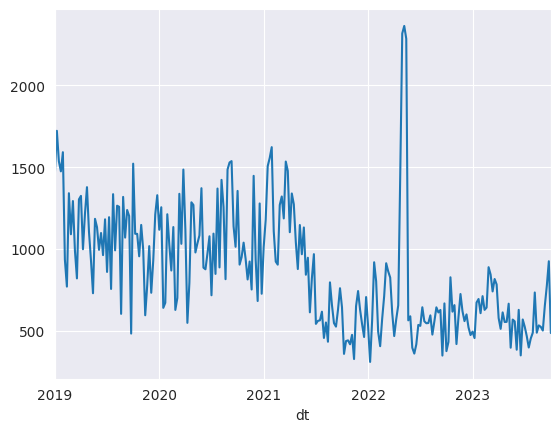

In [91]:
weather_weekly_df['RADIACAO GLOBAL (Kj/m²)'].plot()

<Axes: xlabel='dt'>

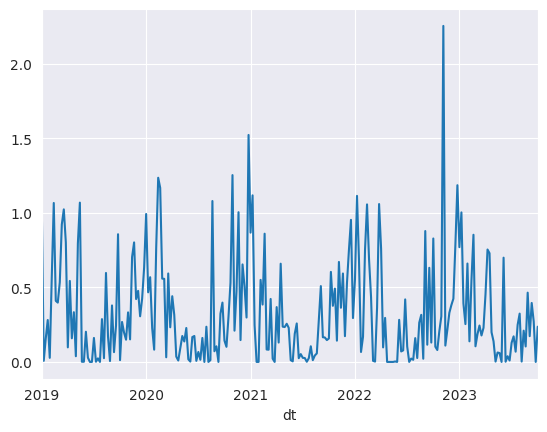

In [92]:
weather_weekly_df['PRECIPITAÇÃO TOTAL, HORÁRIO (mm)'].plot()

Text(1.0, 0.75, '2021')

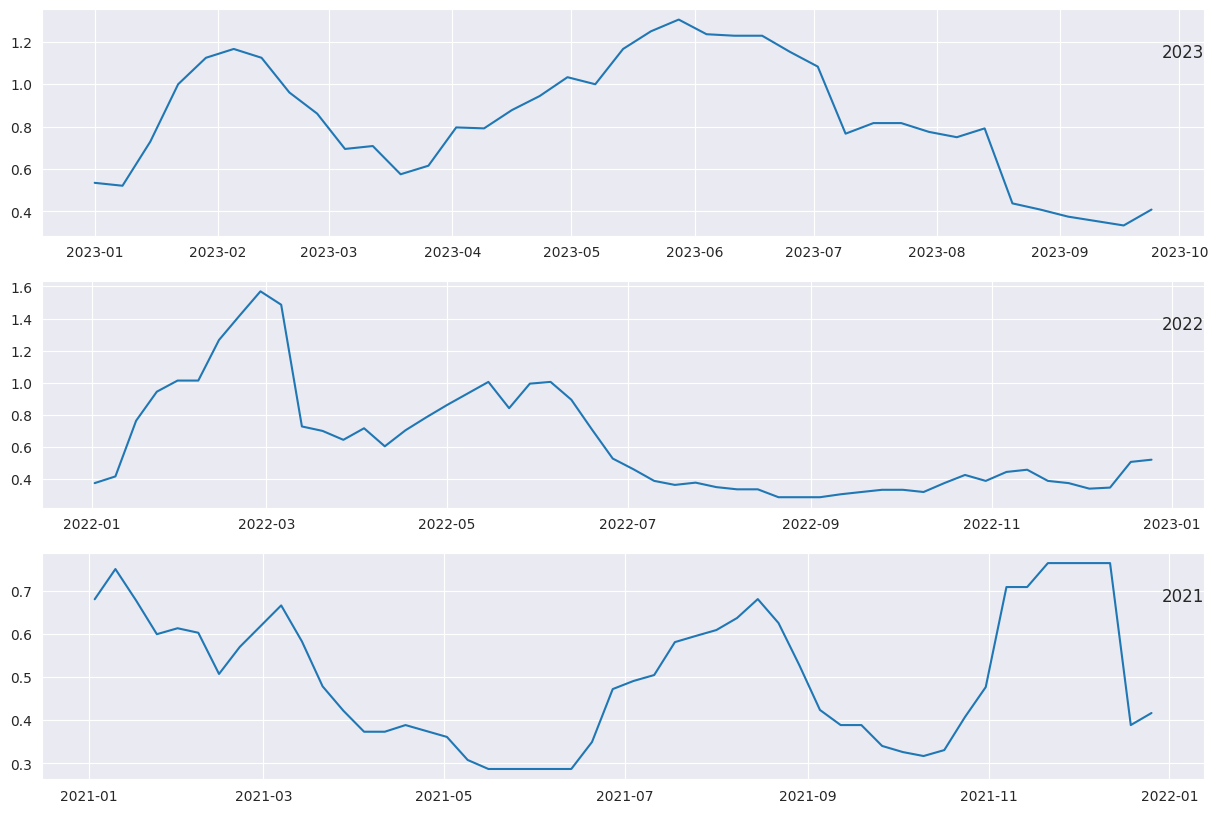

In [93]:
precos_2023 = filtered_alface_crespa_roca.loc[(filtered_alface_crespa_roca.index>= '2023-01-01')& (filtered_alface_crespa_roca.index < '2023-12-31')]

precos_2022 = filtered_alface_crespa_roca.loc[(filtered_alface_crespa_roca.index>= '2022-01-01')& (filtered_alface_crespa_roca.index < '2022-12-31')]


precos_2021 = filtered_alface_crespa_roca.loc[(filtered_alface_crespa_roca.index>= '2021-01-01')& (filtered_alface_crespa_roca.index < '2021-12-31')]

#.plot(title='Soma Preço unitário x Semana')
plt.figure(figsize=(15, 10))


plt.subplot(3, 1, 1)
plt.plot(precos_2023.Preco_unitario.resample('W').mean())
plt.title("2023", y=0.75, loc='right')

plt.subplot(3, 1, 2)
plt.plot(precos_2022.Preco_unitario.resample('W').mean())
plt.title("2022", y=0.75, loc='right')

plt.subplot(3, 1, 3)
plt.plot(precos_2021.Preco_unitario.resample('W').mean())
plt.title("2021", y=0.75, loc='right')

<Axes: xlabel='dt'>

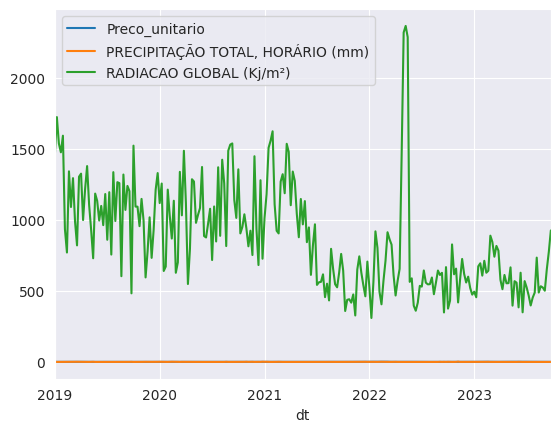

In [94]:
prices_after_2019 = filtered_alface_crespa_roca[filtered_alface_crespa_roca.index >= '2019-01-01']

price_weather_df = pd.merge(prices_after_2019, weather_weekly_df, on='week', how='left')
price_weather_df.index = prices_after_2019.index

price_weather_df[['Preco_unitario', 'PRECIPITAÇÃO TOTAL, HORÁRIO (mm)', 'RADIACAO GLOBAL (Kj/m²)']].plot()



In [95]:

price_weather_numeric_df = price_weather_df[['Preco_unitario', 'PRECIPITAÇÃO TOTAL, HORÁRIO (mm)', 'RADIACAO GLOBAL (Kj/m²)']]

price_precipitation = price_weather_numeric_df[['Preco_unitario', 'PRECIPITAÇÃO TOTAL, HORÁRIO (mm)']]

price_precipitation_values = price_precipitation.values
price_precipitation_values

train_size = 123
validation_size = 62
test_size = 62

values_train = price_precipitation_values[0:train_size]
values_validation = price_precipitation_values[train_size:train_size+validation_size]
values_test = price_precipitation_values[train_size+validation_size:247]

scaler = MinMaxScaler(feature_range=(0, 1))
scaled_train = scaler.fit_transform(values_train)
scaled_validation = scaler.transform(values_validation)
scaled_test = scaler.transform(values_test)


In [96]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	dff = pd.DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(dff.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(dff.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = pd.concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

In [97]:


reframed_train = series_to_supervised(scaled_train, 1, 1)
reframed_validation = series_to_supervised(scaled_validation, 1, 1)
reframed_test = series_to_supervised(scaled_test, 1, 1)
reframed_train

,var1(t-1),var2(t-1),var1(t),var2(t)
1,0.203361,0.703834,0.308377,0.004695
2,0.308377,0.004695,0.258713,0.102504
3,0.258713,0.102504,0.280943,0.184664
4,0.280943,0.184664,0.461451,0.017997
5,0.461451,0.017997,0.641959,0.372457
...,...,...,...,...
118,0.139357,0.241571,0.139357,0.085361
119,0.139357,0.085361,0.159933,0.432778
120,0.159933,0.432778,0.141586,0.155356
121,0.141586,0.155356,0.123239,0.153649


In [98]:
scaled_train

array([[2.03360732e-01, 7.03834116e-01],
       [3.08376921e-01, 4.69483568e-03],
       [2.58713173e-01, 1.02503912e-01],
       [2.80943104e-01, 1.84663537e-01],
       [4.61451217e-01, 1.79968701e-02],
       [6.41959330e-01, 3.72456964e-01],
       [7.62796221e-01, 7.00312989e-01],
       [7.77620623e-01, 2.69170579e-01],
       [8.67314261e-01, 2.61345853e-01],
       [9.57007899e-01, 3.51330203e-01],
       [1.00000000e+00, 6.05633803e-01],
       [9.38474061e-01, 6.72143975e-01],
       [6.41959330e-01, 5.27386541e-01],
       [5.95257792e-01, 6.41627543e-02],
       [4.10679974e-01, 3.56807512e-01],
       [3.75840628e-01, 1.04068858e-01],
       [4.42557109e-01, 2.19092332e-01],
       [3.08376921e-01, 2.50391236e-02],
       [6.44881512e-02, 5.21909233e-01],
       [6.44881512e-02, 7.01877934e-01],
       [2.37243809e-02, 7.82472613e-04],
       [5.85637276e-02, 7.82472613e-04],
       [3.08376921e-01, 1.33020344e-01],
       [3.55078459e-01, 1.87793427e-02],
       [4.106799

(122, 1, 2) (122,) (61, 1, 2) (61,)
Epoch 1/100
2/2 - 5s - loss: 0.1049 - val_loss: 0.3783 - 5s/epoch - 2s/step
Epoch 2/100
2/2 - 0s - loss: 0.0979 - val_loss: 0.3632 - 35ms/epoch - 17ms/step
Epoch 3/100
2/2 - 0s - loss: 0.0919 - val_loss: 0.3484 - 35ms/epoch - 18ms/step
Epoch 4/100
2/2 - 0s - loss: 0.0863 - val_loss: 0.3338 - 39ms/epoch - 19ms/step
Epoch 5/100
2/2 - 0s - loss: 0.0806 - val_loss: 0.3196 - 41ms/epoch - 20ms/step
Epoch 6/100
2/2 - 0s - loss: 0.0743 - val_loss: 0.3057 - 38ms/epoch - 19ms/step
Epoch 7/100
2/2 - 0s - loss: 0.0705 - val_loss: 0.2921 - 45ms/epoch - 23ms/step
Epoch 8/100
2/2 - 0s - loss: 0.0647 - val_loss: 0.2788 - 40ms/epoch - 20ms/step
Epoch 9/100
2/2 - 0s - loss: 0.0607 - val_loss: 0.2659 - 42ms/epoch - 21ms/step
Epoch 10/100
2/2 - 0s - loss: 0.0566 - val_loss: 0.2533 - 40ms/epoch - 20ms/step
Epoch 11/100
2/2 - 0s - loss: 0.0510 - val_loss: 0.2411 - 40ms/epoch - 20ms/step
Epoch 12/100
2/2 - 0s - loss: 0.0481 - val_loss: 0.2293 - 41ms/epoch - 20ms/step
Epoch

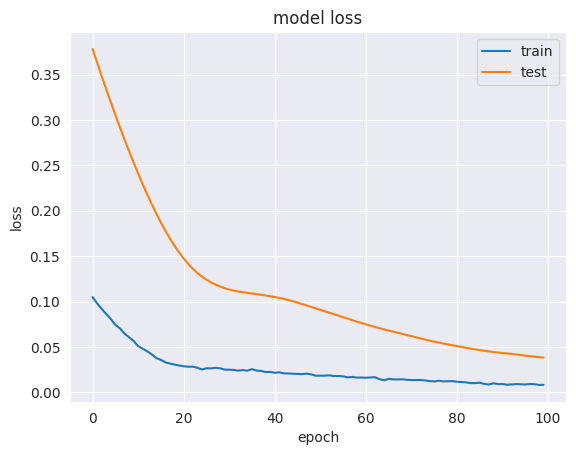

In [99]:
# drop columns we don't want to predict
reframed_train.drop(reframed_train.columns[[3]], axis=1, inplace=True)
reframed_validation.drop(reframed_validation.columns[[3]], axis=1, inplace=True)
reframed_test.drop(reframed_test.columns[[3]], axis=1, inplace=True)

#split into input and output
train_X, train_Y = reframed_train.values[:, :-1], reframed_train.values[:, -1]
validation_X, validation_Y = reframed_validation.values[:, :-1], reframed_validation.values[:, -1]
test_X, test_Y = reframed_test.values[:, :-1], reframed_test.values[:, -1]

# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
validation_X = validation_X.reshape((validation_X.shape[0], 1, validation_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_Y.shape, test_X.shape, test_Y.shape)

model = Sequential()
model.add(LSTM(100, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

# fit network
history = model.fit(train_X, train_Y, epochs=100, batch_size=70, validation_data=(validation_X, validation_Y), verbose=2, shuffle=False)

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

In [100]:
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], 2))

2/2 [==============================] - 0s 3ms/step


In [ ]:
# invert scaling for forecast
inv_yhat = np.concatenate((yhat, test_X[:, -1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
inv_yhat

In [ ]:
# invert scaling for actual
test_Y = test_Y.reshape((len(test_Y), 1))
inv_y = np.concatenate((test_Y, test_X[:, -1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

In [115]:
inv_yhat

array([0.39085494, 0.37644983, 0.36206432, 0.37041372, 0.337678  ,
       0.32792331, 0.35611109, 0.34372917, 0.37126452, 0.36367507,
       0.38792806, 0.3531186 , 0.39121634, 0.43240743, 0.40942581,
       0.52348333, 0.45218337, 0.40605148, 0.40041468, 0.37751493,
       0.38378279, 0.51619518, 0.54318499, 0.53662347, 0.53572033,
       0.67139498, 0.88435587, 1.01686772, 1.01742932, 1.00942323,
       0.88788418, 0.76155712, 0.63375082, 0.64744131, 0.54159463,
       0.57468246, 0.72847913, 0.74056191, 0.81055692, 0.83485599,
       0.90484194, 0.8684928 , 1.0121708 , 1.0832027 , 1.12654038,
       1.11699072, 1.06104543, 1.0637419 , 0.99674773, 0.94613614,
       0.68965728, 0.72378493, 0.73376522, 0.70439605, 0.66754773,
       0.71158508, 0.43683609, 0.4295794 , 0.39464157, 0.38784331,
       0.36864284])

In [114]:

# calculate RMSE
rmse = np.sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 0.120


<Axes: xlabel='dt'>

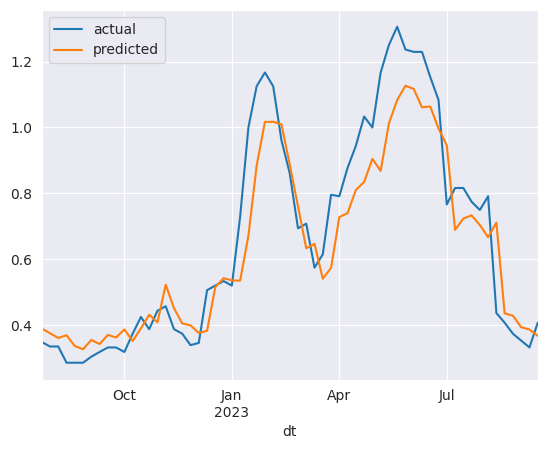

In [120]:
comparison_df = pd.DataFrame({'actual': inv_y, 'predicted': inv_yhat}, index=price_weather_df.index[train_size+validation_size:246])
comparison_df.plot()